In [9]:
import torch 
import torch.nn as nn 

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [10]:
final_time = 1
num_timesteps = 1000
num_paths = 1

dt = final_time/num_timesteps

mu = 0.1
sigma = 0.01

rng = np.random.default_rng(123)

$dS_t = \mu  dt + \sigma dW_t$

In [11]:
brownian_motion = rng.standard_normal(size=(num_timesteps-1, num_paths))

prices = [np.ones((1, num_paths))]
for i in range(0, num_timesteps):

    prices.append(prices[-1] + mu * dt + sigma * rng.standard_normal(size=(1, num_paths))*(dt**0.5))

prices = np.vstack(prices)

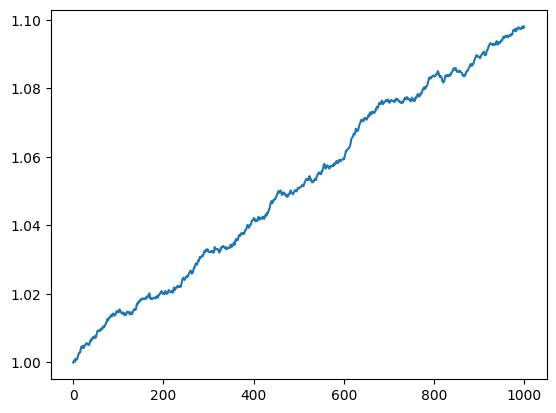

In [12]:
plt.plot(prices)
plt.show()

In [13]:
class ParameterEstimator(nn.Module):

    def __init__(self):
        super().__init__()
        
        self._log_sigma = nn.Parameter(data=torch.log(torch.FloatTensor([1])), requires_grad=True)

        self._drift = nn.Parameter(data=torch.FloatTensor([1]), requires_grad=True)

    @property
    def sigma(self):
        return torch.exp(self._log_sigma)
    
    @property
    def mu(self):
        return self._drift

In [14]:
network = ParameterEstimator()
optimizer = torch.optim.Adam(params=network.parameters(),lr=1e-3)

In [15]:
mu_tracker = []
sigma_tracker = []
loss_tracker = []
for epoch in tqdm(range(10_000)):

    # loss_tensor = torch.FloatTensor([0])
    for timestep in range(0, num_timesteps - 1):

        s_t = torch.FloatTensor(prices[timestep, :])
        s_t_plus_one = torch.FloatTensor(prices[timestep + 1, :])

        L_x_t = network.sigma

        term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * dt))
        
        f_x_t = network.mu 
        term_two = (((s_t_plus_one - s_t) - f_x_t*dt) ** 2)  / (2 * dt * (L_x_t**2))

        loss = (term_one + term_two).mean()

        # loss_tensor += loss

        # loss = loss_tensor.mean()

        loss_tracker.append(loss.detach().item())

        mu_tracker.append(network.mu.detach().item())
        sigma_tracker.append(network.sigma.detach().item())

        network.zero_grad()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        network.zero_grad()
        optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

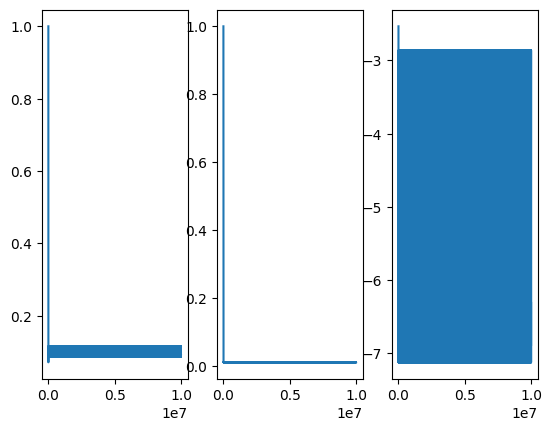

In [16]:
fig, ax = plt.subplots(1,3)
ax[0].plot(mu_tracker)
ax[1].plot(sigma_tracker)
ax[2].plot(loss_tracker)
plt.show()